In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils.visualize_util import plot
from keras.layers import Merge, merge
from keras.layers import Input
from keras import callbacks
import matplotlib.pyplot as plt
import time
import itertools
import json
from keras.models import model_from_json
from collections import Counter
from itertools import izip
from sklearn.manifold import TSNE
import os
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
import keras.callbacks
from keras.callbacks import ModelCheckpoint



filename_model = '_bilingual_keras_output/english_json.txt'
weights = '_bilingual_keras_output/english_weights.h5'

with open(filename_model) as data_file1:    
    data1 = json.load(data_file1)

mono_model = model_from_json(json.dumps(data1))
mono_model.load_weights(weights)

filename_model = '_bilingual_keras_output/bilingual_json.txt'
weights = '_bilingual_keras_output/bilingual_weights.h5'

with open(filename_model) as data_file1:    
    data1 = json.load(data_file1)

bi_model = model_from_json(json.dumps(data1))
bi_model.load_weights(weights)



Using Theano backend.


(4, 4)
[[  1.76175429e-04   4.00024564e-05]
 [  9.89112397e-05   2.18878074e-04]
 [  1.85459526e-04  -9.40225942e-05]
 [  9.54369309e-05  -1.39264259e-05]]


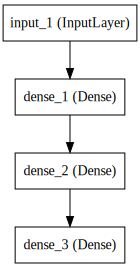

In [14]:
print mono_model.layers[3].get_weights()[0].shape

X = mono_model.layers[3].get_weights()[0]
tsne_model = TSNE(n_components=2, random_state=0)
print tsne_model.fit_transform(X) 

SVG(model_to_dot(mono_model).create(prog='dot', format='svg'))


[array([[ 2.14581728, -0.07849294, -0.28278583],
       [-0.14867061,  0.9816798 ,  0.02883432],
       [ 0.        ,  0.        ,  1.        ]], dtype=float32), array([-0.39793718,  0.00276767,  1.12602556], dtype=float32), array([[-0.01442386,  1.36969423, -1.19641745, -0.03035698],
       [-0.01896751,  0.03565705,  0.22808591,  0.02278585],
       [ 0.02280026, -0.00605218,  0.68584555, -0.02442775]], dtype=float32), array([ -2.53282748e-02,   2.82219239e-02,   6.15046322e-01,
        -1.34999518e-05], dtype=float32), array([[-0.03652897, -0.02381084,  0.00150968,  0.01455416],
       [-0.77774566,  1.03023469, -0.17602335, -0.11251332],
       [ 1.07095408, -0.96958053, -0.10761246, -0.12237456],
       [ 0.01377018,  0.03996072, -0.03478393, -0.02784591]], dtype=float32), array([ 1.15648448,  1.23269427, -1.19012511, -1.19905651], dtype=float32)]

[array([[ 1.7082516 , -0.42735323, -0.25432134],
       [ 0.26024786,  1.93305051,  0.13075809],
       [ 0.        ,  0.        ,  1.

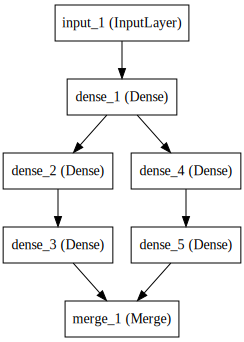

In [15]:
print mono_model.get_weights()
print
print bi_model.get_weights()

SVG(model_to_dot(bi_model).create(prog='dot', format='svg'))



In [16]:
def set_pca_weights(pca_filepath):
    '''expects a file with weight on a each new line '''
    pca_results = open(data_directory+pca_filepath,'r')
    pca_weights = np.zeros((PCA_dimension+1,PCA_dimension+1))
    i = 0
    for line in pca_results:
        a = float(line.strip())
        pca_weights[i][i] = a
        i +=1
    pca_weights[i][i] = 1.0
    # unsure what to set the language gate to start at
    # currently set to 1
    bias = np.concatenate((np.zeros(PCA_dimension),np.ones(1)))
    pca_results.close()
    return [pca_weights,bias]

def load_language_data(language):
  ''' 1. seperate train and test better
      2. change number of iterations for test/train
      dut_x = situation#, 56 floats \n
      dut_y = preposition number \n
  '''
  f = open(data_directory+language+'_x','r')
  g = open(data_directory+language+'_y','r')
  h = open(data_directory+'golden_'+language,'r')
  situation_x_data = {}
  x_train = []
  y_train = []
  x_validation = []
  y_validation =[]
  x_test = []
  y_test = []
  situation_train = []

  for x_line,y_line in izip(f,g):
    x_data = x_line.strip().split(',')
    y_data = y_line.strip().split(',')
    x_data.insert(PCA_dimension+1,0)

    sit_num = int(x_data[0])
    situation_train += [sit_num] # list of all training situations

    situation_x_data[sit_num] = map(float,x_data[1:])
    # print x_data
    x_train += [x_data[1:]]
    y = [0 for x in range(dut_num_preps + ger_num_preps)]
    y[map(int,y_data)[0]] = 1
    y_train += [y]

  #first add language feature
  sit_number_to_preps = make_sit_to_prep(language)
  xy_test_data, test_situation = make_test_data(language,sit_number_to_preps, situation_x_data)
  for xy in xy_test_data:
    x_test += [xy[:-1]]
    y = [0 for x in range(dut_num_preps + ger_num_preps)]
    y[xy[-1:][0]] = 1
    # y[] = 1
    y_test += [y]

  x_validation = x_test
  y_validation = y_test

  #add a bunch of asserts, about sizes, and types of things
  # print len(test_situation[0])

  # counting_situations(situation_train)

  return x_train, y_train, x_validation, y_validation, x_test, y_test, test_situation

def counting_situations(situations):
  g = open(data_directory+language+'_y','r')
  y_s = []
  for y_line in g:
    y_data = y_line.strip().split(',')
    y_s += map(int,y_data)
  preps = []
  for y in y_s:
    preps += [prep_num_to_prep(language,y)]
  c = Counter(zip(situations,preps))
  print sorted(c.items())

def prep_num_to_prep(language, prep_num):
  for key in term_indices[language].keys():
    if(prep_num == term_indices[language][key]):
      return key

def make_test_data(language,situations_to_preps, situation_x_data):
  ''' should this have to read through all lines '''
  xy_test_data = []
  test_situation  = []
  for situation in situations_to_preps.keys():
    xy = situation_x_data[situation]+[situations_to_preps[situation]]
    xy_test_data += [xy]
    test_situation += [situation]

  return xy_test_data, test_situation

def make_sit_to_prep(language):
  test_data = set([]) # 56(PCA)+1(lang)|label
  situations_to_preps = {} # map 71 situations to the correct preposition number
  f = open(data_directory+'golden_'+language,'r')
  for line in f:
    line = line.strip().split(',')
    #line = 63(sit#),over(prep),probability...
    situations_to_preps[int(line[0])] = term_indices[language][line[1]]
    #add asserts about length of data_structures
  return situations_to_preps


def lang_term_number(language, term):
    print term, data[language][term]

def load_term_indices():
    f = open(data_directory+'term_indices')
    data = json.load(f)
    # for language in data:
    #     print language
    #     print data[language]

def output_experiment(models):
    ''' takes a list of models and
    make a new directory with plots of models
    weights of models, and summary of models'''
    if not os.path.exists(directory):
      os.makedirs(directory)
    for model in models:
        filepath_weights = directory+model.name + '_' + language +'_weights.txt'
        model.save_weights(filepath_weights)

        model.summary()# prints out summaries
        filename = model.name + '_json.txt'
        g = open(directory+'/'+filename,'w')
        g.write(str(model.to_json()))
        g.close()
        plot(model, show_shapes=True, to_file=directory+'/'+model.name+'.png')

def visualize_gates(model):
    x_old = init_gate[0].diagonal()
    x_final = model.get_weights()[0].diagonal()
    x_index = [i for i in range(len(x_old)+1)]
    y_index = [0,1,2,3]

    intensity = np.concatenate(([x_old], [x_final], [np.subtract(x_final,x_old)]), axis=0)

    print x_old
    print x_final
    print np.subtract(x_final, x_old)

#     x, y = np.meshgrid(x_index, y_index)

#     plt.pcolormesh(x, y, intensity)
#     plt.colorbar() #need a colorbar to show the intensity scale
#     plt.show() #boom
    
    

mode = 'synthetic'
language = 'dut'
pca_filepath = 'results_PCA.csv'
training_epoch = 200
if (mode == 'real'):
    time_stamp = time.strftime("%m-%d-%Y-%H-%M")
    data_directory = 'gen_data/'
    german_filepath = 'NEED TO FILL IN'
    dut_num_preps = 14
    ger_num_preps = 10
    PCA_dimension = 56
    language_embedding_dimension = 28
elif(mode =='fake'):
    data_directory = 'fake_data/'
    time_stamp = ''
    dut_num_preps = 2
    ger_num_preps = 3
    PCA_dimension = 3
    language_embedding_dimension = 4
else:
    data_directory = 'synthetic_data/'
    time_stamp = ''
    language = 'lang_1'
    dut_num_preps = 2
    ger_num_preps = 2
    PCA_dimension = 2
    language_embedding_dimension = 4

directory = time_stamp+'_bilingual_keras_output/'
if not os.path.exists(directory):
      os.makedirs(directory)

term_indices = json.load(open(data_directory+'term_indices'))
X_train,y_train, X_validation, y_validation, X_test, y_test, test_situation = load_language_data(language)


In [17]:
right_answer = [0 for x in range(71)]
second_answer = [0 for x in range(71)]
wrong_answer = [0 for x in range(71)]

y_test = np.array(y_test)
for x,y,z in zip(model.predict(X_test, batch_size=1), y_test, test_situation):
  print x, y,z
  
    
  prediction = np.where(x==x.max())[0][0]
  prediction_2 = np.argsort(x)[::-1][1]
  correct_answer = np.where(y==y.max())[0][0]
  if(prediction == correct_answer):
    right_answer[z-1] += 1
  elif(prediction_2 == correct_answer):
    second_answer[z-1] += 1
  else:
    # print " " + str(prediction), correct_answer
    wrong_answer[z-1] += 1
  for key, value in term_indices[language].iteritems():
    if value == prediction:
      break
    
  print z,key #this prints out situation, preposition predicted


print "sums of right, 2nd, wrong"
print sum(right_answer)
print sum(second_answer)
print sum(wrong_answer)

print



NameError: name 'model' is not defined

In [18]:
for i in range(len(second_answer)):
  if(wrong_answer[i] + second_answer[i] == 1):
    print i+1

In [ ]:
language = 'lang_2'
sgd = SGD(lr=0.1, decay=1e-6)
checkpointer = ModelCheckpoint(filepath=directory+language+'_weights.{epoch:02d}.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
remote = callbacks.RemoteMonitor(root='http://localhost:9000')

X_train,y_train, X_validation, y_validation, X_test, y_test, test_situation = load_language_data('lang_2')
bi_model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])
bi_model.fit(X_train, y_train, batch_size=1, validation_data=(X_validation, y_validation),
    nb_epoch=training_epoch, callbacks=[remote,checkpointer])

# [ 1.  1.  1.]
# [ 2.14581728  0.9816798   1.        ]
# [ 1.14581728 -0.0183202   0.        ]

Train on 100 samples, validate on 100 samples
Epoch 1/200
100/100 [==============================] - 0s - loss: 0.1148 - acc: 0.8900 - val_loss: 0.0994 - val_acc: 1.0000
Epoch 2/200
100/100 [==============================] - 0s - loss: 0.0979 - acc: 0.9700 - val_loss: 0.0907 - val_acc: 0.9900
Epoch 3/200
100/100 [==============================] - 0s - loss: 0.0907 - acc: 0.9800 - val_loss: 0.0879 - val_acc: 0.9500
Epoch 4/200
100/100 [==============================] - 0s - loss: 0.0860 - acc: 0.9800 - val_loss: 0.0827 - val_acc: 0.9900
Epoch 5/200
100/100 [==============================] - 0s - loss: 0.0821 - acc: 0.9800 - val_loss: 0.0859 - val_acc: 0.9700
Epoch 6/200
100/100 [==============================] - 0s - loss: 0.0821 - acc: 0.9700 - val_loss: 0.0783 - val_acc: 0.9900
Epoch 7/200
100/100 [==============================] - 0s - loss: 0.0793 - acc: 0.9900 - val_loss: 0.0759 - val_acc: 0.9900
Epoch 8/200
100/100 [==============================] - 0s - loss: 0.0795 - acc: 0.9700

In [ ]:
gate_weights = set_pca_weights(pca_filepath)
init_gate = gate_weights
visualize_gates(bi_model)
